In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
from pytorch_lightning import Trainer
from pl_module import CMPNNLitModel, MultiCMPNNLitModel
from dataset import CMPNNDataset, MultiCMPNNDataset
from preprocessing import scaffold_split_indices
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import Subset

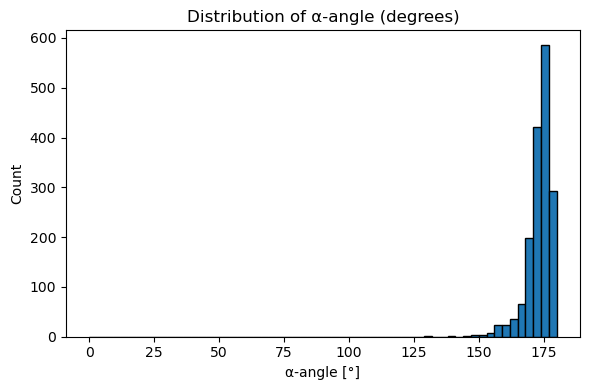

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# assume df is your DataFrame, angles in radians

import pandas as pd
import matplotlib.pyplot as plt

# 1) ensure numeric dtype
df['alpha_angle'] = pd.to_numeric(df['alpha_angle'], errors='coerce')

# 2) drop any NaNs that crept in during conversion
alpha = df['alpha_angle'].dropna()

# 3) plot histogram in degrees from 0 to 180
plt.figure(figsize=(6,4))
plt.hist(
    alpha,
    bins=60,
    range=(0, 180),
    density=False,      # raw counts
    edgecolor='black'
)
plt.title("Distribution of α-angle (degrees)")
plt.xlabel("α-angle [°]")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


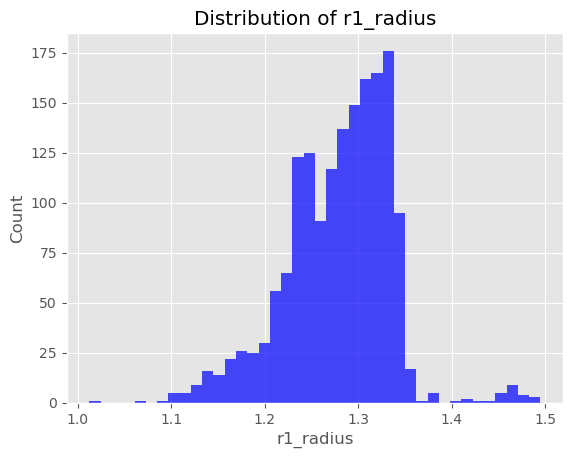

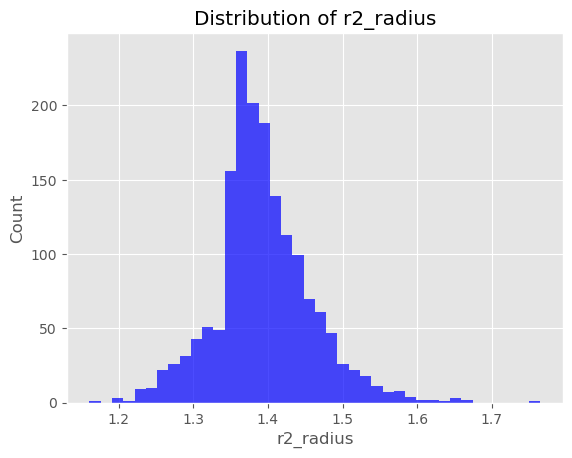

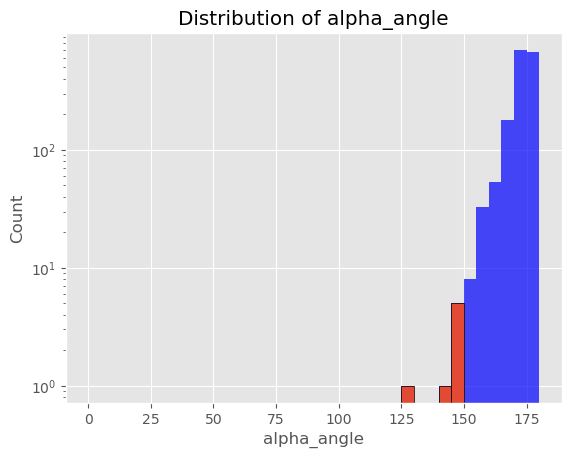

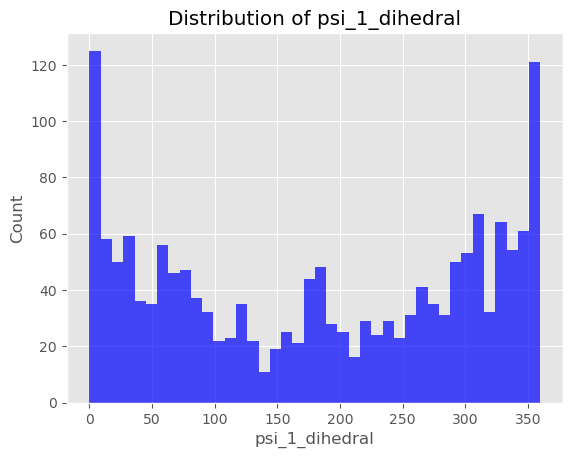

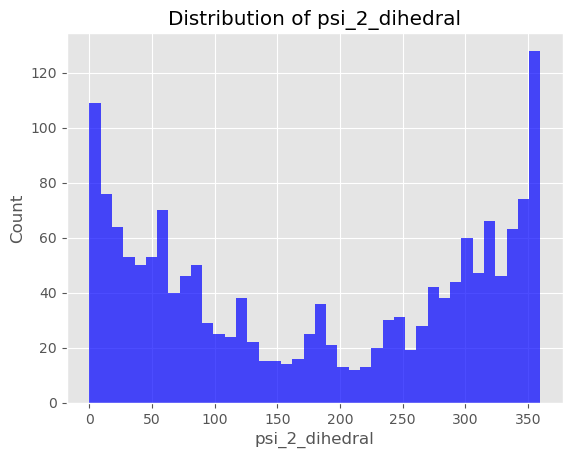

In [23]:
import matplotlib.pyplot as plt
df = pd.read_csv("/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv")
# Change matplotlib style to ggplot
plt.style.use('ggplot')
# Identify numeric columns (exclude 'rxn')
numeric_cols = ['r1_radius', 'r2_radius', 'alpha_angle', 'psi_1_dihedral', 'psi_2_dihedral']
# drop -10 values
for col in numeric_cols:
    df = df[df[col] != -10]
df['alpha_angle'] = pd.to_numeric(df['alpha_angle'], errors='coerce')
for col in numeric_cols:
    plt.figure()
    if col == 'alpha_angle':
        bins = range(0, 185, 5)         # 5° bins from 0 to 180
        outlier_mask = alpha < 150     # those below 150°
        plt.hist(df[col].dropna(), bins=bins, range=(0,180), density=False, alpha=0.7, color='blue', label="150°–180°",)
        plt.hist(
    alpha[outlier_mask],
    bins=bins,
    color="C0",
    edgecolor="black",
    label="< 150°",
)   
        plt.yscale("log")
    else:
        plt.hist(df[col].dropna(), bins=40, density=False, alpha=0.7, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

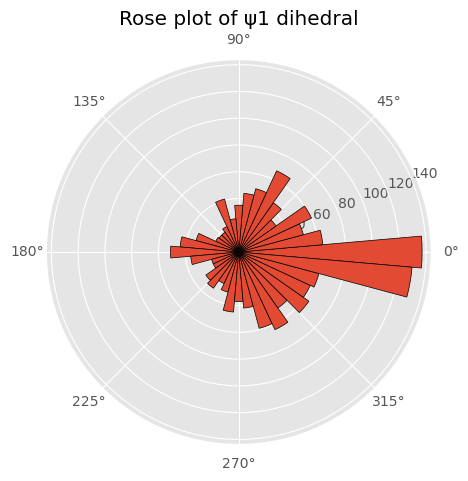

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# assume df['psi_1_dihedral'] is in degrees [0,360)
angles = np.deg2rad(df['psi_1_dihedral'].dropna())
# drop -10 values
angles = angles[angles != -10]

plt.figure(figsize=(5,5))
n_bins = 36
counts, bin_edges = np.histogram(angles, bins=n_bins)
width = 2*np.pi / n_bins

ax = plt.subplot(projection='polar')
ax.bar(bin_edges[:-1], counts, width=width, bottom=0.0, edgecolor='k')
ax.set_title("Rose plot of ψ1 dihedral")
plt.show()


In [31]:
from scipy.stats import circmean, circstd

# in radians
# remove -10 values
angles = df['psi_1_dihedral'].dropna()
# drop -10 values
angles = angles[angles != -10]
psi1 = np.deg2rad(angles)
mu1   = circmean(psi1, high=2*np.pi, low=0)
kappa1 = 1 / (circstd(psi1, high=2*np.pi, low=0)**2)

print(f"ψ₁ mean direction = {np.rad2deg(mu1):.1f}°")
print(f"ψ₁ concentration ≈ {kappa1:.1f}")


ψ₁ mean direction = 355.4°
ψ₁ concentration ≈ 0.4


In [33]:
from scipy.stats import circmean, circstd

# in radians
# remove -10 values
angles2 = df['psi_2_dihedral'].dropna()
# drop -10 values
angles2 = angles2[angles2 != -10]
psi2 = np.deg2rad(angles2)
mu1   = circmean(psi2, high=2*np.pi, low=0)
kappa1 = 1 / (circstd(psi2, high=2*np.pi, low=0)**2)

print(f"ψ₁ mean direction = {np.rad2deg(mu1):.1f}°")
print(f"ψ₁ concentration ≈ {kappa1:.1f}")


ψ₁ mean direction = 2.5°
ψ₁ concentration ≈ 0.5


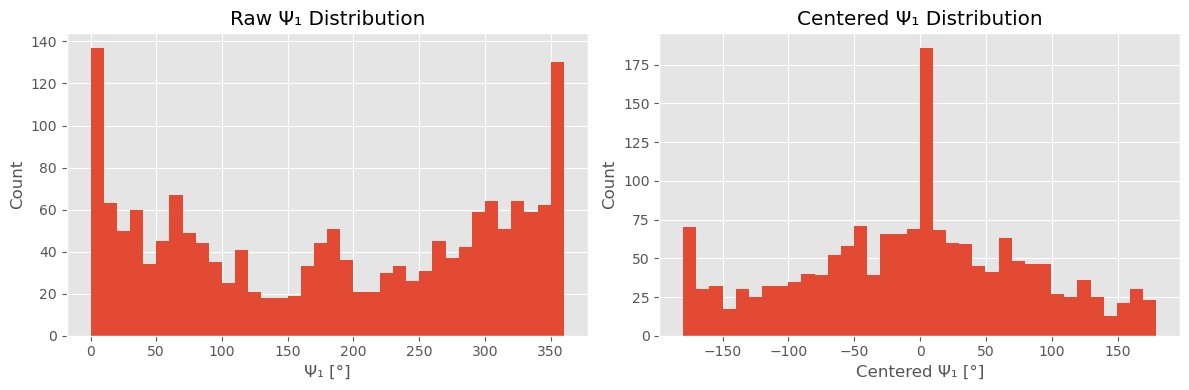

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Extract raw dihedral angles (psi_1) in degrees from your full dataset
# Here we assume that `dm` is your DataModule and that `full_ds` is the underlying MultiCMPNNDatasetSDF


# Convert to radians
angles_deg = df['psi_1_dihedral'].values
# Drop -10 values
angles_deg = angles_deg[angles_deg != -10]
angles = np.deg2rad(angles_deg)

# Compute circular mean
sin_sum = np.sin(angles).mean()
cos_sum = np.cos(angles).mean()
mean_dir = np.arctan2(sin_sum, cos_sum)

# Center angles around zero
centered = ((angles - mean_dir) + np.pi) % (2 * np.pi) - np.pi

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(angles_deg, bins=36)
axes[0].set_title("Raw Ψ₁ Distribution")
axes[0].set_xlabel("Ψ₁ [°]")
axes[0].set_ylabel("Count")

axes[1].hist(np.rad2deg(centered), bins=36)
axes[1].set_title("Centered Ψ₁ Distribution")
axes[1].set_xlabel("Centered Ψ₁ [°]")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


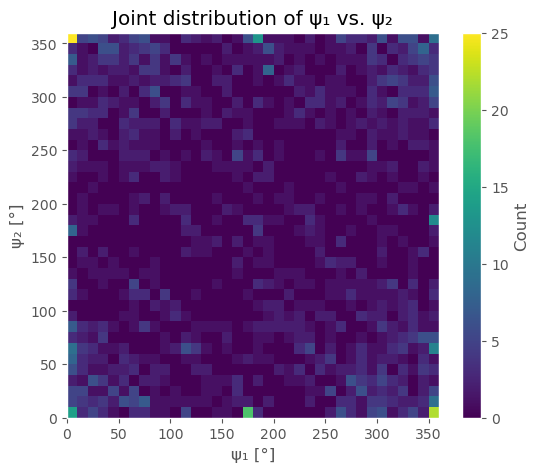

In [32]:
angles2 =df['psi_2_dihedral'].dropna()
# drop -10 values
angles2 = angles2[angles2 != -10]
plt.figure(figsize=(6,5))
plt.hist2d(angles, angles2,
           bins=36, cmap="viridis")
plt.colorbar(label="Count")
plt.xlabel("ψ₁ [°]"); plt.ylabel("ψ₂ [°]")
plt.title("Joint distribution of ψ₁ vs. ψ₂")
plt.show()


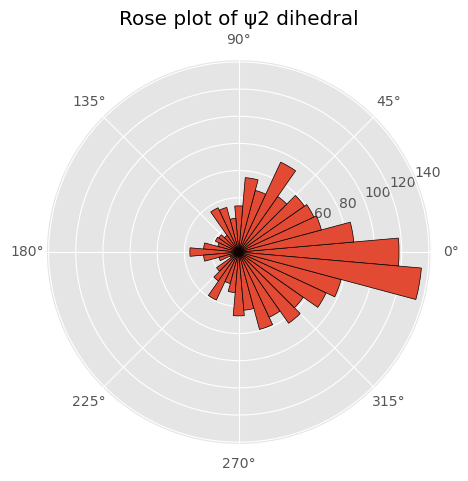

In [29]:
import matplotlib.pyplot as plt

# assume df['psi_1_dihedral'] is in degrees [0,360)
angles = np.deg2rad(df['psi_2_dihedral'].dropna())
# drop -10 values
angles = angles[angles != -10]

plt.figure(figsize=(5,5))
n_bins = 36
counts, bin_edges = np.histogram(angles, bins=n_bins)
width = 2*np.pi / n_bins

ax = plt.subplot(projection='polar')
ax.bar(bin_edges[:-1], counts, width=width, bottom=0.0, edgecolor='k')
ax.set_title("Rose plot of ψ2 dihedral")
plt.show()


In [ ]:
2 dihedral")
plt.show()


In [17]:
df_path = "./raw/multi_mols.csv"
full_ds = MultiCMPNNDataset(root='.', csv_file=os.path.basename(df_path), atom_messages=True, force_reload=True)


Processing...
Done!


In [3]:
full_ds[0]

(Data(x=[24, 133], edge_index=[2, 54], edge_attr=[54, 12], y=[1]),
 Data(x=[33, 133], edge_index=[2, 70], edge_attr=[70, 12], y=[1]))

In [4]:
print(len(full_ds))

100


In [5]:
# Random split
from preprocessing import random_split_indices

In [6]:
train_idx, test_idx, val_idx = random_split_indices(full_ds)

In [7]:
len(train_idx)

80

In [8]:
mean, std = full_ds.compute_normalization(train_idx)

In [27]:
full_ds.apply_normalization()

In [28]:
# 6) create train/val/test splits
train_ds = Subset(full_ds, train_idx)
val_ds = Subset(full_ds, val_idx)
test_ds = Subset(full_ds, test_idx)

In [29]:
from utils_paired import collate_pairs
# Use pytorch pure data loader
from torch.utils.data import DataLoader
# 7) create dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pairs)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
sample_pairs = [train_ds[i] for i in range(4)]   # 4 tuple-pairs
batch        = collate_pairs(sample_pairs)       # now returns one Batch
print(type(batch), batch.num_graphs)             # Batch 8

batch.num_graphs

<class 'abc.DataBatch'> 8


8

In [30]:
batch = next(iter(train_loader))
print(type(batch))

<class 'abc.DataBatch'>


In [31]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score
# Check device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = MultiCMPNNLitModel(
    in_node_feats=full_ds.num_atom_features,
    in_edge_feats=full_ds.num_bond_features,
    hidden_dim=300,
    num_steps=3,
    dropout_mp=0.1,
    dropout_head=0.1,
    n_tasks=full_ds.num_targets,
    metrics=[MeanSquaredError(squared=False), MeanAbsoluteError().to(device=device), R2Score().to(device=device)],
    lr=1e-4,
    weight_decay=1e-5,
    target_mean=full_ds.mean,
    target_std=full_ds.std,
    mpn_shared=True
)

In [1]:
from pytorch_lightning.callbacks import EarlyStopping
trainer = Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    logger=False,
    # Allow for early stopping
    callbacks=[EarlyStopping(monitor="val_rmse_unscaled", patience=10)],
    enable_checkpointing=False,
    enable_progress_bar=True,
)
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

NameError: name 'Trainer' is not defined